In [1]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


Region Stimuli
=========================

This tutorial describes the process of adding a stimulation defined at the 
region level to a simulation. Within TVB, Stimuli can be specified at either
the region or surface level, with the latter only applying to the case of
simulations including a mesh representation of the cortical surface. Stimuli
defined at the region level can also be applied to a surface level simulation.
In that case the stimuli applied to cortical regions are mapped to all 
vertices belonging to that region. 

Here, we will define a basic stimulus at the region level and apply it to a 
region level simulation. We'll use a fairly boring deterministic simulation
so that the effects of the stimuli are very clear.

Defining the Stimuli
--------------------

We'll begin by just arbitrarily selecting some nodes and defining the weighting
of the stimuli coming into those nodes, to show what the basic process looks like.

In [173]:
conn = connectivity.Connectivity(load_default=True)

# configure stimulus spatial pattern
weighting = numpy.zeros((76, ))
weighting[[14, 52, 11, 49]] = 0.1

WARNING  File 'hemispheres' not found in ZIP.


We now need to define the temporal profile. This is done by selecting
an equation and setting its parameters as desired, here we'll just take
the default Gaussian, with the only change being that we'll shift the 
midpoint to 16ms. 

An important thing to note is that, the time defined for the stimuli is
relative to a call of the Simulator. That is, if you run a simulation for 
100ms, and then run the same simulator for a further 100ms (note: continuation
of this sort is discussed in another tutorial) then you'll end up with the
same stimuli repeated 

In [225]:
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 1.5e3
eqn_t.parameters['T'] = 100.0
eqn_t.parameters['tau'] = 50.0

Now we need to combine these spatial and temporal components into a StimuliRegion object,
which can then be used in the construction of our simulator

In [226]:
stimulus = patterns.StimuliRegion(
    temporal=eqn_t,
    connectivity=conn,
    weight=weighting)

We can take a quick look at the basic structure of the stimuli we've just defined using
one of the built in plotting tools.

The plotting tool we'll use provides a simple overview of the stimuli's structure. It 
assumes the stimulus object is already configured, so we start by configuring the object.
This configuration step is actually taken care of automagically within the simulator, so
when you don't want to look at your stimuli before running a simulation this step isn't 
necessary.

NOTE: while the information necessary to configure space is provided by the Connectivity
object, for time it is necessary to explicitly provide a time vector. When a simulation
is run, this time vector is generated internally based on the integration scheme's dt and
the simulation length requested when you call the simulator.

<IPython.core.display.Javascript object>


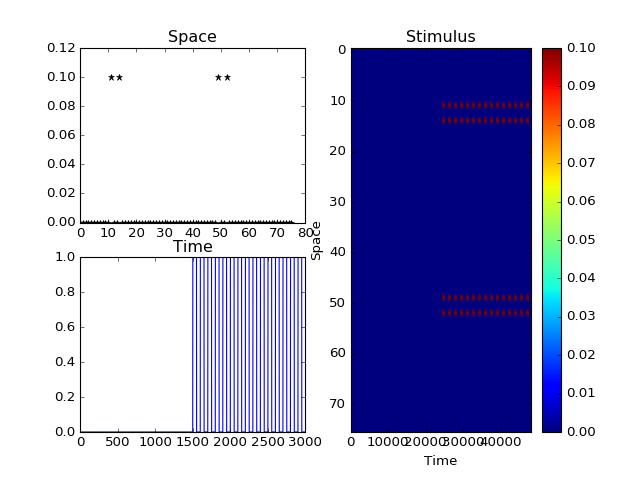

In [227]:
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 3e3, 2**-4))

#And take a look
plot_pattern(stimulus)

What you should see above are three plots: top-left is the spatial component of the stimuli,
indicating the strength with which the stimuli enters each node; bottom-left is the temporal 
profile for the stimuli; and the colour plot on the right represents the combination of these
two components.

## Simulate

Now, we just create & run the simulation,

In [233]:
sim = simulator.Simulator(
    model=models.Generic2dOscillator(a=0.3, tau=2),
    connectivity=conn,
    coupling=coupling.Difference(a=7e-4),
    integrator=integrators.HeunStochastic(dt=0.5, noise=noise.Additive(nsig=5e-5)),
    monitors=(
        monitors.TemporalAverage(period=1.0),
        ),
    stimulus=stimulus,
    simulation_length=5e3, # 1 minute simulation
).configure()

(tavg_time, tavg_data),  = sim.run()

One specific thing here is that, because simulations started without ideal initial conditions can 
often have a large transient at the start of the simulation, we need to run the simulator for 
a bit to clear this transient, otherwise the transient would dominate our stimuli and be difficult
to see in the resulting data.

NOTE: If you have a strong stimuli with long-lasting effects on the dynamics, it is possible to 
effectively turn off the stimuli for the purpose of running this initial transient clearing step
and then reinitialise it before running the main simulation.

## Visualize

<IPython.core.display.Javascript object>


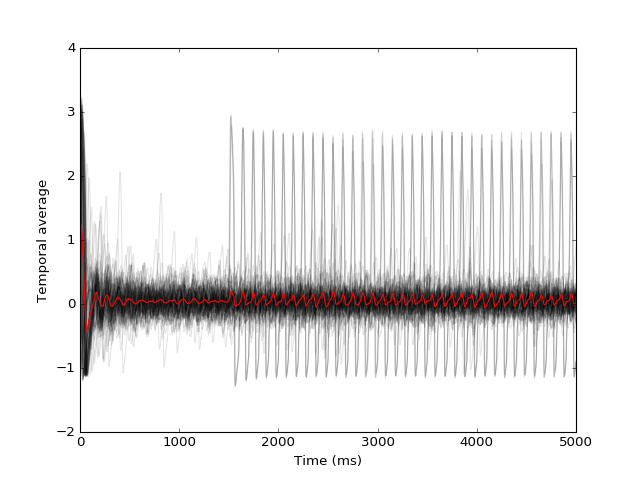

In [234]:
figure()
plot(tavg_time, tavg_data[:, 0, :, 0], 'k', alpha=0.1)
plot(tavg_time, tavg_data[:, 0, :, 0].mean(axis=1), 'r', alpha=1)
ylabel("Temporal average")
xlabel('Time (ms)')


If you look closely at the time-series above you'll notice that oscillations occur in 
nodes not directly stimulated, this, of course, is an effect of the activity propagating
across the brain network defined by the Connectivity.

In [235]:
import tvb.datatypes.time_series
tsr = tvb.datatypes.time_series.TimeSeriesRegion(
    data=tavg_data,
    connectivity=conn,
    sample_period=sim.monitors[0].period / 1000.0, 
    sample_period_unit="s")
tsr.configure()
tsr

Time-series name,
Time-series type,TimeSeriesRegion
Dimensions,"['Time', 'State Variable', 'Region', 'Mode']"
Region Mapping,None
Sample period,0.001
Length,5.0
Region Mapping Volume,None
Time units,s
Source Connectivity,Connectivity 76


<IPython.core.display.Javascript object>


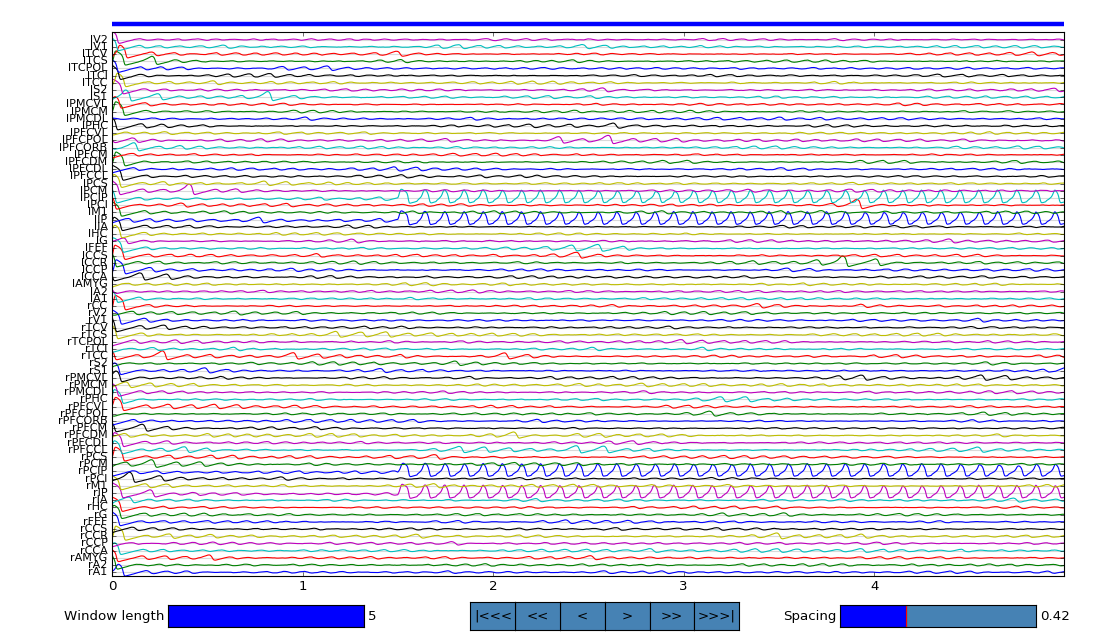

In [236]:
import tvb.simulator.plot.timeseries_interactive as ts_int
tsi = ts_int.TimeSeriesInteractive(time_series=tsr)
tsi.configure()
tsi.show()

We've discussed stimuli that are defined at the region level, and as we noted above, 
these can also be applied to surface simulations. However, surface simulations 
provide the additional possibility of defining the spatial component by an equation
evaluated as a function of distance from one or more focal points on the cortical 
surface -- this is described in more detail in "Tutorial: Surface Stimuli".

Alternatively, we have mentioned the continuation of simulations above, which is 
something that provides a great deal of flexibility to how you run simulations,
for example in reproducing repetitive or block structured experimental paradigms,
so you might want to have a look at that tutorial.